***Part 1 : Import Statements***

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import Xception, VGG19, EfficientNetB0, InceptionV3

***Part 2 : Loading the datasets + Running the Models + Testing***


# Xception

### A. *Training the model with E-Commerce Images*

In [2]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

In [3]:
# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

In [4]:
# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

In [5]:
# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [6]:
# Paths to your datasets
train_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\train"
valid_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')

train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")

Datasets prepared.
Train class names: ['Blouse' 'Boots' 'Cap' 'Coat' 'Dress' 'Gloves' 'Hat' 'Hoodie' 'Jacket'
 'Jumpsuit' 'Pants' 'Romper' 'Scarf' 'Shirt' 'Shoes' 'Shorts' 'Skirt'
 'Sleepwear' 'Socks' 'Suit' 'Sweater' 'Sweatpant' 'Swimwear' 'T_Shirt'
 'Tie' 'Underwear' 'Vest']
Valid class names: ['Blouse' 'Boots' 'Cap' 'Coat' 'Dress' 'Gloves' 'Hat' 'Hoodie' 'Jacket'
 'Jumpsuit' 'Pants' 'Romper' 'Scarf' 'Shirt' 'Shoes' 'Shorts' 'Skirt'
 'Sleepwear' 'Socks' 'Suit' 'Sweater' 'Sweatpant' 'Swimwear' 'T_Shirt'
 'Tie' 'Underwear' 'Vest']


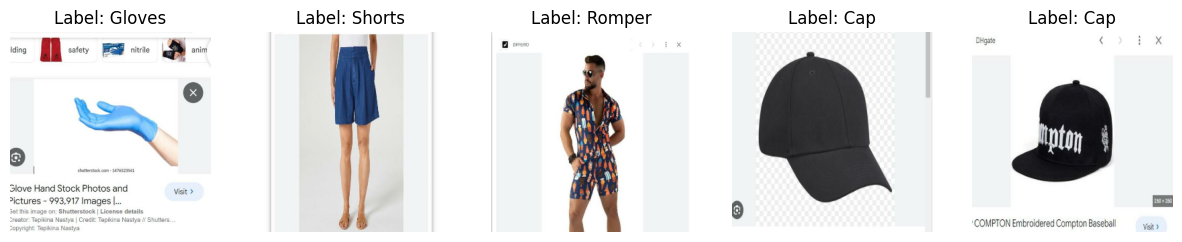

In [7]:
# Display some training images
display_images(train_dataset, train_class_names)

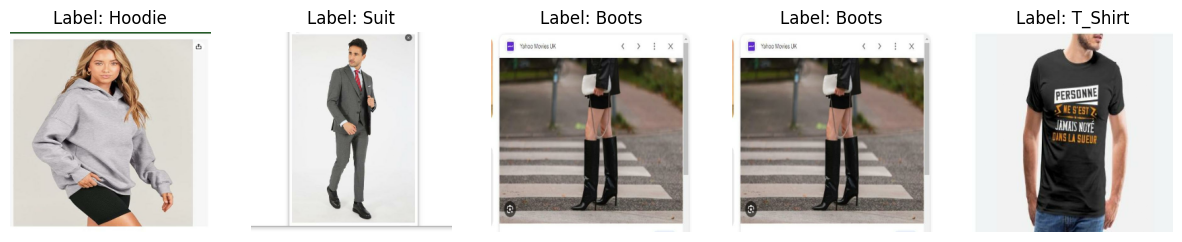

In [8]:
# Display some validation images
display_images(valid_dataset, valid_class_names)

In [9]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [10]:
# Load the pre-trained Xception model
base_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

In [11]:
# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

Epoch 1/10
20/20 [==============================] - 101s 5s/step - loss: 2.3211 - accuracy: 0.3987 - val_loss: 1.3074 - val_accuracy: 0.5968
Epoch 2/10
20/20 [==============================] - 74s 4s/step - loss: 0.9182 - accuracy: 0.7476 - val_loss: 0.7916 - val_accuracy: 0.8226
Epoch 3/10
20/20 [==============================] - 71s 4s/step - loss: 0.5038 - accuracy: 0.8810 - val_loss: 0.5862 - val_accuracy: 0.8387
Epoch 4/10
20/20 [==============================] - 69s 3s/step - loss: 0.3058 - accuracy: 0.9325 - val_loss: 0.5131 - val_accuracy: 0.8387
Epoch 5/10
20/20 [==============================] - 71s 4s/step - loss: 0.2604 - accuracy: 0.9421 - val_loss: 0.4457 - val_accuracy: 0.8548
Epoch 6/10
20/20 [==============================] - 70s 4s/step - loss: 0.1519 - accuracy: 0.9678 - val_loss: 0.4414 - val_accuracy: 0.8226
Epoch 7/10
20/20 [==============================] - 69s 3s/step - loss: 0.1090 - accuracy: 0.9775 - val_loss: 0.3719 - val_accuracy: 0.8871
Epoch 8/10
20/20 [=

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

2/2 [==============================] - 6s 3s/step - loss: 0.3544 - accuracy: 0.8871
Validation accuracy: 88.71%


- Testing on the e-commerce dataset (itself)

In [15]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

1/1 [==============================] - 4s 4s/step


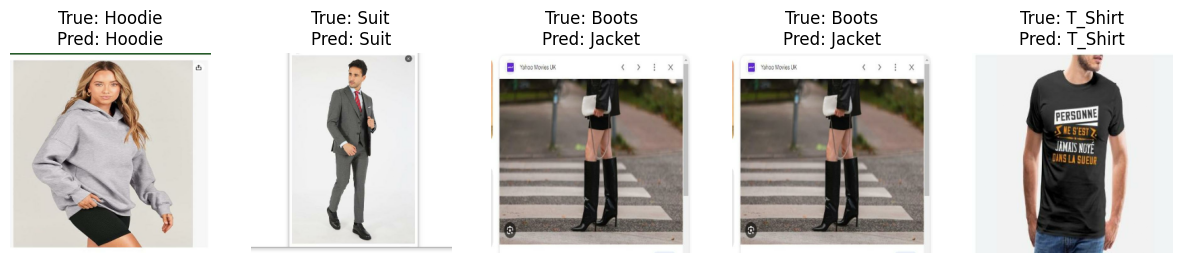

In [16]:
# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

- Testing on the runway dataset

In [17]:
import tensorflow as tf
import pandas as pd
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset
import os
import matplotlib.pyplot as plt

In [18]:
# Create the dataset
valid_images_new = create_dataset(
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid",
    r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv'
)

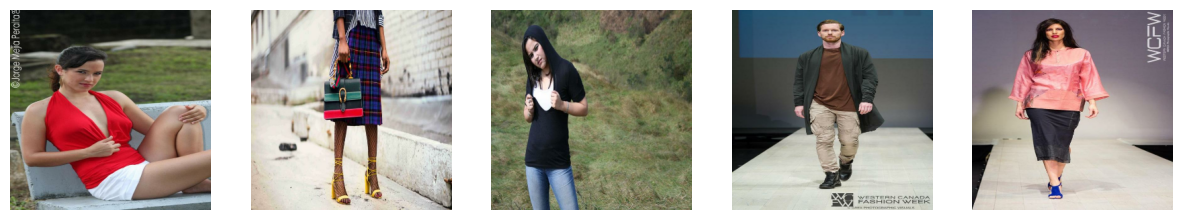

In [19]:
# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.axis('off')
    plt.show()

# Display the images
display_images(valid_images_new, num_images=5)


1/1 [==============================] - 0s 160ms/step


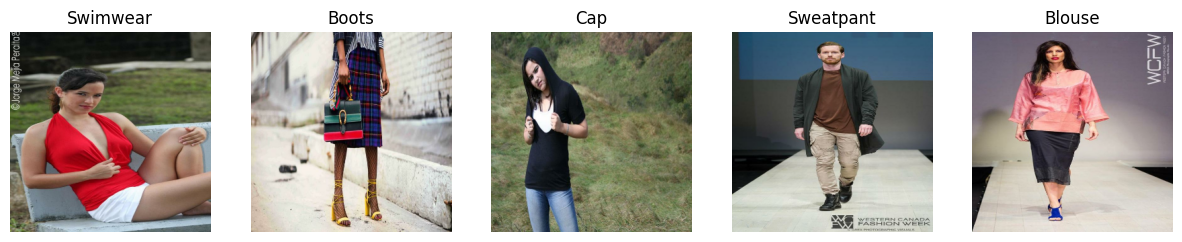

In [20]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, image in enumerate(dataset.take(num_images)):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(predicted_class)
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, valid_images_new, num_images=5)

- Testing on the social media dataset

In [21]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

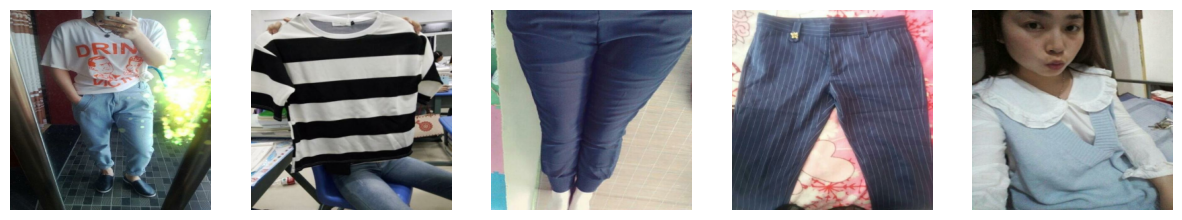

In [22]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.axis('off')
    plt.show()

# Display the images
display_images(test_images_new, num_images=5)

1/1 [==============================] - 0s 159ms/step


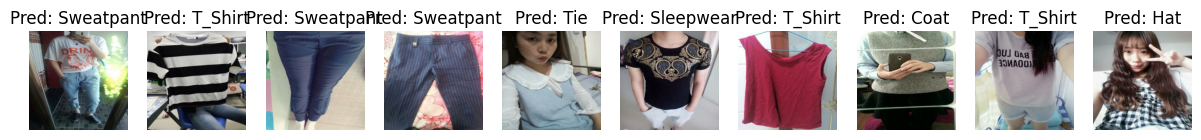

In [23]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=10)


### B. *Training the model with Runway Images*

In [24]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image, label

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file, class_names):
    annotations = pd.read_csv(annotations_file)
    grouped = annotations.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': lambda x: x.tolist(),
        'xmin': lambda x: x.tolist(),
        'ymin': lambda x: x.tolist(),
        'xmax': lambda x: x.tolist(),
        'ymax': lambda x: x.tolist()
    }).reset_index()

    image_paths = [os.path.join(image_dir, fname) for fname in grouped['filename']]
    labels = grouped['class'].apply(lambda x: [class_names.index(cls) for cls in x])

    # Convert labels to binary format
    binarized_labels = np.zeros((len(labels), len(class_names)))
    for i, label_list in enumerate(labels):
        binarized_labels[i, label_list] = 1

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, binarized_labels))
    dataset = dataset.map(lambda img_path, label: load_and_preprocess_image(img_path, label))
    return dataset

In [25]:
# Paths to your dataset
train_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train'
valid_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid'
test_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test'

train_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train\_annotations.csv"
valid_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
test_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test\_annotations.csv"

In [26]:
# Load class names
class_names = pd.read_csv(train_annotations_file)['class'].unique().tolist()

# Create datasets
train_dataset = create_dataset(train_image_dir, train_annotations_file, class_names)
test_dataset = create_dataset(test_image_dir, test_annotations_file, class_names)

In [27]:
# Function to create Xception-based model
def create_model(num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='sigmoid')(x)


    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [28]:
# Create the model
model = create_model(len(class_names))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(32),
                    epochs=10,
                    validation_data=test_dataset.batch(32))

Epoch 1/10
94/94 [==============================] - 300s 3s/step - loss: 0.2530 - accuracy: 0.2361 - val_loss: 0.2496 - val_accuracy: 0.4419
Epoch 2/10
94/94 [==============================] - 11182s 120s/step - loss: 0.2023 - accuracy: 0.2522 - val_loss: 0.2408 - val_accuracy: 0.4651
Epoch 3/10
94/94 [==============================] - 280s 3s/step - loss: 0.1861 - accuracy: 0.2676 - val_loss: 0.2375 - val_accuracy: 0.3256
Epoch 4/10
94/94 [==============================] - 272s 3s/step - loss: 0.1738 - accuracy: 0.2605 - val_loss: 0.2380 - val_accuracy: 0.4884
Epoch 5/10
94/94 [==============================] - 3215s 35s/step - loss: 0.1619 - accuracy: 0.2769 - val_loss: 0.2380 - val_accuracy: 0.4186
Epoch 6/10
94/94 [==============================] - 543s 6s/step - loss: 0.1515 - accuracy: 0.2595 - val_loss: 0.2409 - val_accuracy: 0.3488
Epoch 7/10
94/94 [==============================] - 2733s 29s/step - loss: 0.1424 - accuracy: 0.2669 - val_loss: 0.2432 - val_accuracy: 0.3488
Epoch

In [29]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 [==============================] - 8s 2s/step - loss: 0.2567 - accuracy: 0.3953
Test Accuracy: 39.53%


In [30]:
# Predict on the test dataset
predictions = model.predict(test_dataset.batch(32))

2/2 [==============================] - 10s 2s/step


- Testing on runway images (itself)

In [31]:
# Function to visualize images with predictions
def visualize_predictions(test_dataset, predictions, class_names, num_images=5):
    for images, labels in test_dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_labels = np.where(labels[i] == 1)[0]
            pred_labels = np.where(predictions[i] >= 0.5)[0]
            true_class_names = [class_names[idx] for idx in true_labels]
            pred_class_names = [class_names[idx] for idx in pred_labels]
            plt.title(f"True: {', '.join(true_class_names)}\nPred: {', '.join(pred_class_names)}")
            plt.axis("off")
        plt.show()

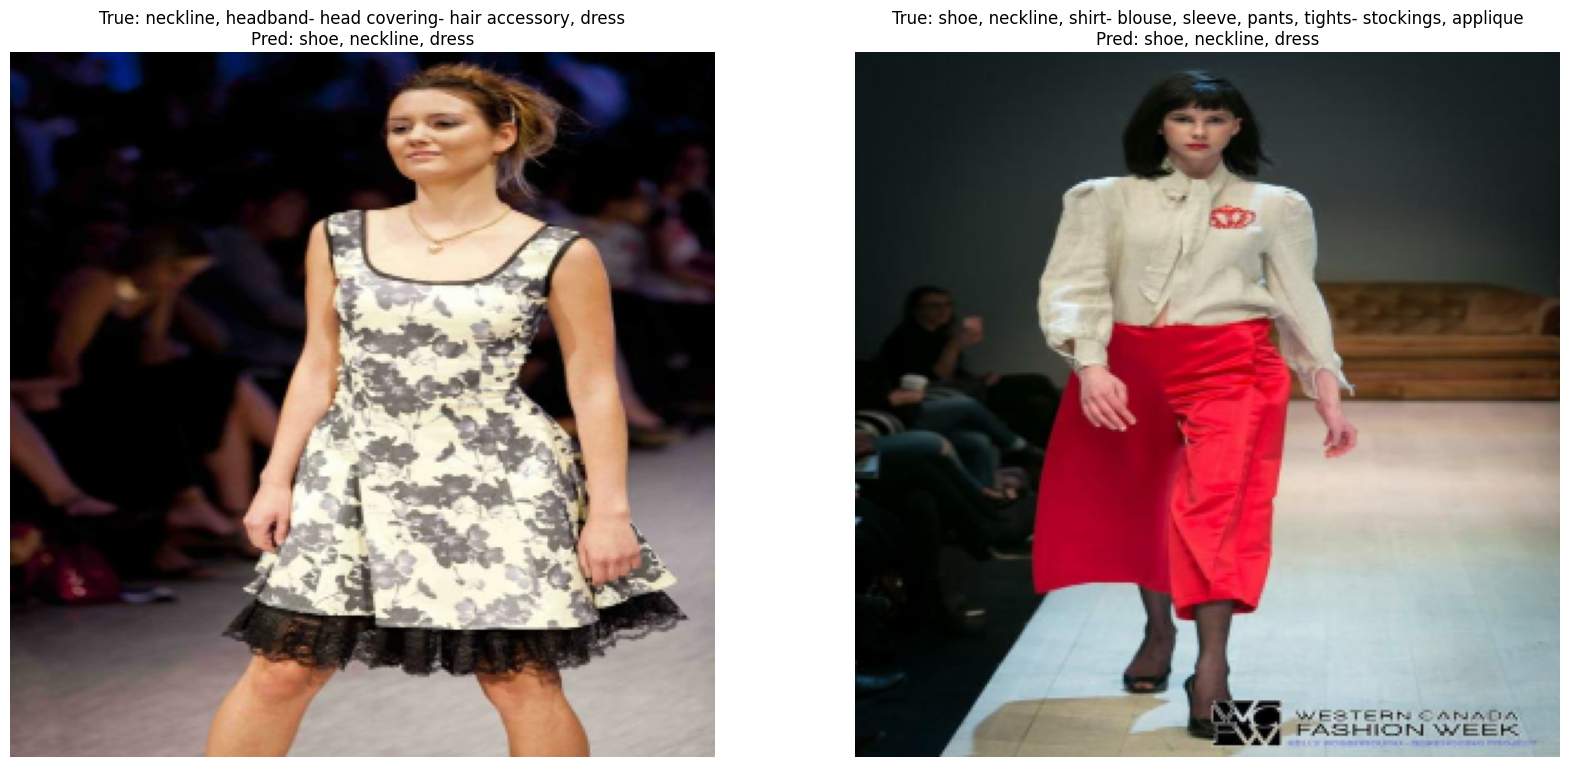

In [32]:
# Visualize predictions
visualize_predictions(test_dataset.batch(32), predictions, class_names, num_images=2)

- Testing on e-commerce images

In [33]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [34]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [35]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))

2/2 [==============================] - 13s 5s/step


In [36]:
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()

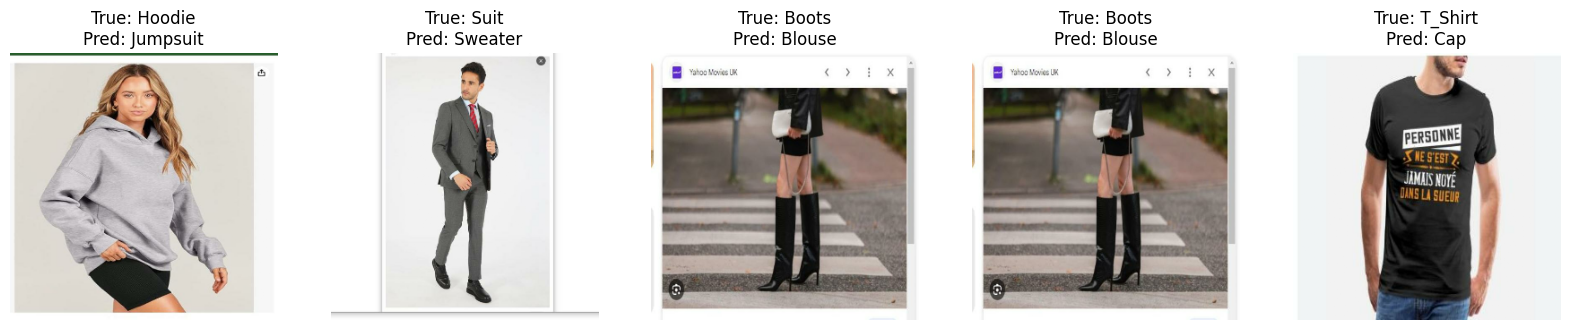

In [37]:
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on social media images

In [38]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

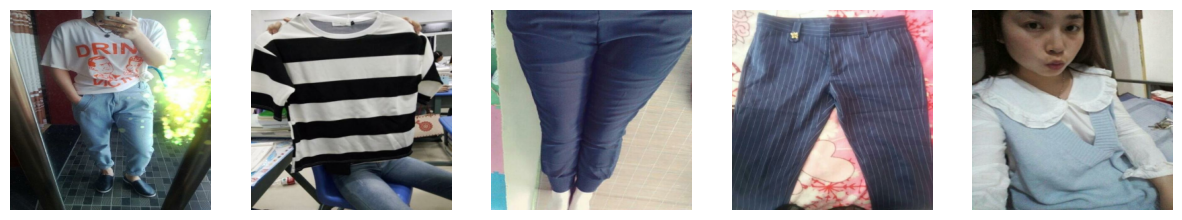

In [39]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.axis('off')
    plt.show()

# Display the images
display_images(test_images_new, num_images=5)

1/1 [==============================] - 0s 433ms/step


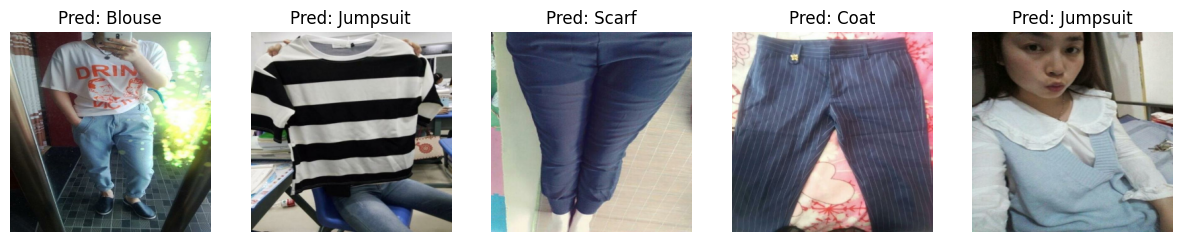

In [40]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### C. *Training the model with Social Media Images*

In [2]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [3]:
# Paths to your datasets
train_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\train"
valid_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
test_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')
test_annotations_file = os.path.join(test_dir, '_annotations.csv')

train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)
test_dataset, test_class_names = create_tf_dataset(test_dir, test_annotations_file)

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")
print(f"Test class names: {test_class_names}")

Datasets prepared.
Train class names: ['long sleeve dress' 'long sleeve outwear' 'long sleeve top'
 'short sleeve dress' 'short sleeve outwear' 'short sleeve top' 'shorts'
 'skirt' 'sling' 'sling dress' 'trousers' 'vest' 'vest dress']
Valid class names: ['long sleeve dress' 'long sleeve outwear' 'long sleeve top'
 'short sleeve dress' 'short sleeve outwear' 'short sleeve top' 'shorts'
 'skirt' 'sling' 'sling dress' 'trousers' 'vest' 'vest dress']
Test class names: ['long sleeve dress' 'long sleeve outwear' 'long sleeve top'
 'short sleeve dress' 'short sleeve outwear' 'short sleeve top' 'shorts'
 'skirt' 'sling' 'sling dress' 'trousers' 'vest' 'vest dress']


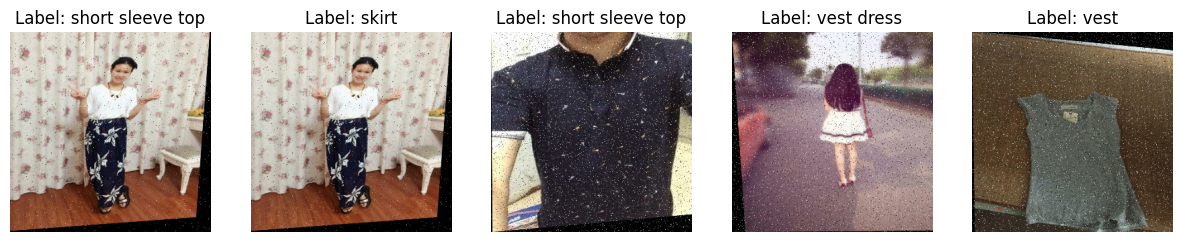

In [4]:
# Display some training images
display_images(train_dataset, train_class_names)

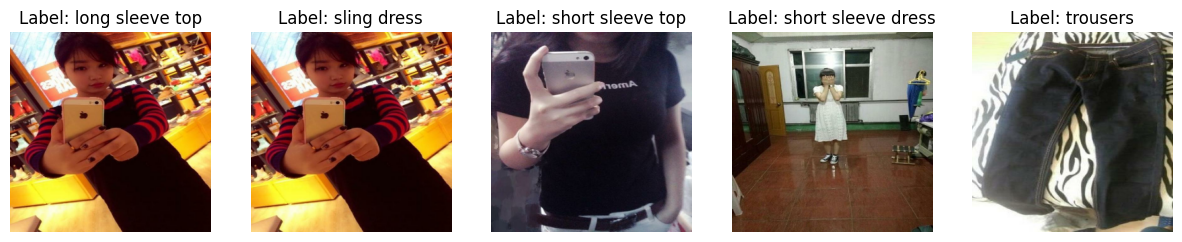

In [5]:
# Display some validation images
display_images(valid_dataset, valid_class_names)

In [6]:
# Number of classes in the dataset
num_classes = len(train_class_names)
print(num_classes)

13


In [ ]:
# Load the pre-trained Xception model
base_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)    # Takes so much time 30 mins min = 1 epoch

Epoch 1/10
 29/478 [>.............................] - ETA: 49:21 - loss: 2.3450 - accuracy: 0.2392

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

- Testing on social media images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

In [ ]:
# Visualize predictions on the test dataset
visualize_predictions(test_dataset, model, test_class_names)

- Testing on e-commerce dataset

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on runway images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

# EfficientNetB0

### A. *Training the model with E-Commerce Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size for EfficientNet input
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file, batch_size=32):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\train'
valid_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid'

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')

# Create datasets
train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")

In [ ]:
# Display some training images
display_images(train_dataset, train_class_names)

In [ ]:
# Display some validation images
display_images(valid_dataset, valid_class_names)

In [ ]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

- Testing on e-commerce images (itself)


In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

- Testing on runway images

In [ ]:
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

In [ ]:
# Create the dataset
valid_images_new = create_dataset(
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid",
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
)

In [ ]:
# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.axis('off')
    plt.show()

# Display the images
display_images(valid_images_new, num_images=5)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, image in enumerate(dataset.take(num_images)):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(predicted_class)
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, valid_images_new, num_images=5)

- Testing on social media images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

In [ ]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### B. *Training the model with Runway Images*

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match EfficientNet input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image, label

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file, class_names):
    annotations = pd.read_csv(annotations_file)
    grouped = annotations.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': lambda x: x.tolist(),
        'xmin': lambda x: x.tolist(),
        'ymin': lambda x: x.tolist(),
        'xmax': lambda x: x.tolist(),
        'ymax': lambda x: x.tolist()
    }).reset_index()

    image_paths = [os.path.join(image_dir, fname) for fname in grouped['filename']]
    labels = grouped['class'].apply(lambda x: [class_names.index(cls) for cls in x])

    # Convert labels to binary format
    binarized_labels = np.zeros((len(labels), len(class_names)))
    for i, label_list in enumerate(labels):
        binarized_labels[i, label_list] = 1

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, binarized_labels))
    dataset = dataset.map(lambda img_path, label: load_and_preprocess_image(img_path, label))
    return dataset

In [ ]:
train_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train"
valid_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
test_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test"

train_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train\_annotations.csv"
valid_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
test_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test\_annotations.csv"

In [ ]:
# Load class names
class_names = pd.read_csv(train_annotations_file)['class'].unique().tolist()

In [ ]:
# Create datasets
train_dataset = create_dataset(train_image_dir, train_annotations_file, class_names)
test_dataset = create_dataset(test_image_dir, test_annotations_file, class_names)
valid_dataset = create_dataset(valid_image_dir, valid_annotations_file, class_names)

In [ ]:
# Function to create EfficientNet-based model
def create_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
# Create the model
model = create_model(len(class_names))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(32),
                    epochs=25,
                    validation_data=test_dataset.batch(32))

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

- Testing on runway images (itself)

In [ ]:
# Predict on the test dataset
predictions = model.predict(test_dataset.batch(32))

In [ ]:
# Function to visualize images with predictions
def visualize_predictions(test_dataset, predictions, class_names, num_images=5):
    for images, labels in test_dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_labels = np.where(labels[i] == 1)[0]
            pred_labels = np.where(predictions[i] >= 0.5)[0]
            true_class_names = [class_names[idx] for idx in true_labels]
            pred_class_names = [class_names[idx] for idx in pred_labels]
            plt.title(f"True: {', '.join(true_class_names)}\nPred: {', '.join(pred_class_names)}")
            plt.axis("off")
        plt.show()

# Visualize predictions
visualize_predictions(test_dataset.batch(32), predictions, class_names, num_images=2)

- Testing on e-commerce images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match EfficientNet input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

In [ ]:
# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))

In [ ]:
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()

In [ ]:
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on social media images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

In [ ]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### C. *Training the model with Social Media Images*


In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Change size if needed based on the model input
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\train"
valid_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
test_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')
test_annotations_file = os.path.join(test_dir, '_annotations.csv')  

train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)
test_dataset, test_class_names = create_tf_dataset(test_dir, test_annotations_file)  

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")
print(f"Test class names: {test_class_names}")

In [ ]:
# Display some validation images
display_images(valid_dataset, valid_class_names)

In [ ]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Load the pre-trained EfficientNet model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

- Testing on social media images (itself)

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Visualize predictions on the test dataset
visualize_predictions(test_dataset, model, test_class_names)

In [ ]:
# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

- Testing on e-commerce images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on runway images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

# VGG19

### A. *Training the model with E-Commerce Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # VGG19 expects 224x224 images
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\train'
valid_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid'

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')

train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")

In [ ]:
# Display some training images
display_images(train_dataset, train_class_names)
# Display some validation images
display_images(valid_dataset, valid_class_names)

In [ ]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

- Testing on e-commerce images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

- Testing on runway images

In [ ]:
# Function to load and preprocess image for VGG19
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size as per VGG19 input requirements
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
# Paths to your new dataset
valid_images_new = create_dataset(
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid",
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
)

In [ ]:
# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.unbatch().take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        image = image + [103.939, 116.779, 123.68]  # Add back the mean RGB values
        image = image[..., ::-1]  # Convert BGR to RGB
        image = tf.cast(image, tf.uint8)  # Convert to uint8 for display
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Display the images
display_images(valid_images_new, num_images=5)

In [ ]:
# Load the pre-trained VGG19 model
num_classes = len(train_class_names)  # Assuming train_class_names is defined and holds your class names

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))

    for idx, image in enumerate(dataset.unbatch().take(num_images)):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        image = image + [103.939, 116.779, 123.68]  # Add back the mean RGB values
        image = image[..., ::-1]  # Convert BGR to RGB
        image = tf.cast(image, tf.uint8)  # Convert to uint8 for display
        plt.imshow(image)
        plt.title(predicted_class)
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, valid_images_new, train_class_names, num_images=5)

- Testing on social media images


In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid\_annotations.csv"
# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

### B. *Training the model with Runway Images*

In [ ]:
# Load the annotation CSV and extract unique class names
def get_class_names(annotation_file):
    df = pd.read_csv(annotation_file)
    return df['class'].unique().tolist()

# Preprocess image for VGG19
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size as per VGG19 input requirements
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

# Create a dataset from image directory and annotation CSV
def create_dataset(image_dir, annotations_file, class_names):
    annotations = pd.read_csv(annotations_file)
    grouped = annotations.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': lambda x: x.tolist(),
        'xmin': lambda x: x.tolist(),
        'ymin': lambda x: x.tolist(),
        'xmax': lambda x: x.tolist(),
        'ymax': lambda x: x.tolist()
    }).reset_index()

    image_paths = [os.path.join(image_dir, fname) for fname in grouped['filename']]
    labels = grouped['class'].apply(lambda x: [class_names.index(cls) for cls in x])

    # Convert labels to binary format
    binarized_labels = np.zeros((len(labels), len(class_names)))
    for i, label_list in enumerate(labels):
        binarized_labels[i, label_list] = 1

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, binarized_labels))
    dataset = dataset.map(lambda img, label: (load_and_preprocess_image(img), label))
    return dataset

# Create the model
def create_model(num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

# Compute accuracy
def compute_accuracy(model, dataset, class_names):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = model.predict(images)
        for i in range(len(predictions)):
            predicted_classes = tf.where(predictions[i] > 0.5).numpy().flatten()
            true_labels.append(labels[i].numpy())
            predicted_labels.append(predicted_classes)

    # Compute accuracy (multi-label)
    accuracy = np.mean([set(np.where(tl == 1)[0]) == set(pl) for tl, pl in zip(true_labels, predicted_labels)])
    return accuracy

In [ ]:
# Paths to your dataset
train_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train"
valid_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
test_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test"

train_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train\_annotations.csv"
valid_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
test_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test\_annotations.csv"

In [ ]:
# Load class names
class_names = get_class_names(train_annotations_file)

# Create the datasets
train_dataset = create_dataset(train_image_dir, train_annotations_file, class_names).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = create_dataset(valid_image_dir, valid_annotations_file, class_names).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = create_dataset(test_image_dir, test_annotations_file, class_names).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Create the model
model = create_model(len(class_names))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=10)

In [ ]:
# Evaluate the model on the test dataset
accuracy = compute_accuracy(model, test_dataset, class_names)
print(f"Accuracy on test dataset: {accuracy * 100:.2f}%")

In [ ]:
# Evaluate the model on the test dataset
accuracy = compute_accuracy(model, valid_dataset, class_names)
print(f"Accuracy on validation dataset: {accuracy * 100:.2f}%")

- Testing on runway images (itself)

In [ ]:
def display_images_with_predictions(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    dataset_iter = iter(dataset.unbatch().batch(1))  # Unbatch the dataset and create an iterator

    for idx in range(num_images):
        image, labels = next(dataset_iter)
        img_array = tf.expand_dims(image[0], 0)  # Expand dimensions to add batch dimension
        predictions = model.predict(img_array)
        predicted_classes = tf.where(predictions[0] > 0.5).numpy().flatten()

        plt.subplot(1, num_images, idx + 1)
        image_np = image[0].numpy() + [103.939, 116.779, 123.68]  # Add back the mean RGB values
        image_np = image_np[..., ::-1]  # Convert BGR to RGB
        plt.imshow(tf.cast(image_np, tf.uint8))  # Reverse preprocessing for display
        predicted_labels = [class_names[i] for i in predicted_classes]
        true_labels = [class_names[i] for i in np.where(labels[0] == 1)[0]]
        plt.title(f"Pred: {predicted_labels}\nTrue: {true_labels}")
        plt.axis('off')

    plt.show()

In [ ]:
# Display the images with predictions from the test dataset
display_images_with_predictions(model, test_dataset, class_names, num_images=2)

- Testing on e-commerce images

In [ ]:
# Load the annotation CSV and extract unique class names
def get_class_names(annotation_file):
    df = pd.read_csv(annotation_file)
    return df['class'].unique().tolist()

# Preprocess image for VGG19
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size as per VGG19 input requirements
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

# Create a dataset from image directory and annotation CSV
def create_dataset(image_dir, annotations_file, class_names):
    annotations = pd.read_csv(annotations_file)
    grouped = annotations.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': lambda x: x.tolist(),
        'xmin': lambda x: x.tolist(),
        'ymin': lambda x: x.tolist(),
        'xmax': lambda x: x.tolist(),
        'ymax': lambda x: x.tolist()
    }).reset_index()

    image_paths = [os.path.join(image_dir, fname) for fname in grouped['filename']]
    labels = grouped['class'].apply(lambda x: [class_names.index(cls) for cls in x])

    # Convert labels to binary format
    binarized_labels = np.zeros((len(labels), len(class_names)))
    for i, label_list in enumerate(labels):
        binarized_labels[i, label_list] = 1

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, binarized_labels))
    dataset = dataset.map(lambda img, label: (load_and_preprocess_image(img), label))
    return dataset

# Compute accuracy
def compute_accuracy(model, dataset, class_names):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = model.predict(images)
        for i in range(len(predictions)):
            predicted_classes = tf.where(predictions[i] > 0.5).numpy().flatten()
            true_labels.append(labels[i].numpy())
            predicted_labels.append(predicted_classes)

    # Compute accuracy (multi-label)
    accuracy = np.mean([set(np.where(tl == 1)[0]) == set(pl) for tl, pl in zip(true_labels, predicted_labels)])
    return accuracy

In [ ]:
# Paths to your new validation dataset
new_valid_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_valid_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Load class names from the new dataset
new_class_names = get_class_names(new_valid_annotations_file)

# Create the new validation dataset
new_valid_dataset = create_dataset(new_valid_image_dir, new_valid_annotations_file, new_class_names).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def display_images_with_predictions(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    dataset_iter = iter(dataset.unbatch().batch(1))  # Unbatch the dataset and create an iterator

    for idx in range(num_images):
        image, labels = next(dataset_iter)
        img_array = tf.expand_dims(image[0], 0)  # Expand dimensions to add batch dimension
        predictions = model.predict(img_array)
        predicted_classes = tf.where(predictions[0] > 0.5).numpy().flatten()

        plt.subplot(1, num_images, idx + 1)
        image_np = image[0].numpy() + [103.939, 116.779, 123.68]  # Add back the mean RGB values
        image_np = image_np[..., ::-1]  # Convert BGR to RGB
        plt.imshow(tf.cast(image_np, tf.uint8))  # Reverse preprocessing for display
        predicted_labels = [class_names[i] for i in predicted_classes]
        true_labels = [class_names[i] for i in np.where(labels[0] == 1)[0]]
        plt.title(f"Pred: {predicted_labels}\nTrue: {true_labels}")
        plt.axis('off')

    plt.show()

In [ ]:
# Display the images with predictions from the new validation dataset
display_images_with_predictions(model, new_valid_dataset, new_class_names, num_images=3)

- Testing on runway images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

### C. *Training the model with Social Media Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your new dataset
new_train_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\train"
new_valid_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
new_test_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"

new_train_annotations_file = os.path.join(new_train_dir, '_annotations.csv')
new_valid_annotations_file = os.path.join(new_valid_dir, '_annotations.csv')
new_test_annotations_file = os.path.join(new_test_dir, '_annotations.csv')

new_train_dataset, new_train_class_names = create_tf_dataset(new_train_dir, new_train_annotations_file)
new_valid_dataset, new_valid_class_names = create_tf_dataset(new_valid_dir, new_valid_annotations_file)
new_test_dataset, new_test_class_names = create_tf_dataset(new_test_dir, new_test_annotations_file)

print("New datasets prepared.")
print(f"New Train class names: {new_train_class_names}")
print(f"New Valid class names: {new_valid_class_names}")
print(f"New Test class names: {new_test_class_names}")

In [ ]:
# Display some training images from the new dataset
display_images(new_train_dataset, new_train_class_names)
# Display some validation images from the new dataset
display_images(new_valid_dataset, new_valid_class_names)

In [ ]:
# Number of classes in the new dataset
new_num_classes = len(new_train_class_names)

In [ ]:
# Load the pre-trained Xception model (you can skip this if you have an existing model to evaluate)
base_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top (you can skip this if you have an existing model to evaluate)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(new_num_classes, activation='softmax')
])

# Compile the model (you can skip this if you have an existing model to evaluate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the new dataset (skip if you only want to evaluate)
history = model.fit(new_train_dataset, validation_data=new_valid_dataset, epochs=10)

In [ ]:
# Evaluate the model on the new validation dataset
loss, accuracy = model.evaluate(new_valid_dataset)
print(f'Validation accuracy on new dataset: {accuracy * 100:.2f}%')

In [ ]:
# Evaluate the model on the new test dataset
test_loss, test_accuracy = model.evaluate(new_test_dataset)
print(f'Test accuracy on new dataset: {test_accuracy * 100:.2f}%')

- Testing on social media images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Visualize predictions on the new validation dataset
visualize_predictions(new_valid_dataset, model, new_valid_class_names)

In [ ]:
# Visualize predictions on the new test dataset
visualize_predictions(new_test_dataset, model, new_test_class_names)

- Testing on e-commerce images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"


# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on runway images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

# InceptionV3

### A. *Training the model with E-Commerce Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size for InceptionV3 input
    image = tf.keras.applications.inception_v3.preprocess_input(image)  # Preprocessing specific to InceptionV3
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values
    
    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\train'
valid_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid'

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')

train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")

In [ ]:
# Display some training images
display_images(train_dataset, train_class_names)

In [ ]:
# Display some validation images
display_images(valid_dataset, valid_class_names)

In [ ]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Load the pre-trained InceptionV3 model
base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

- Testing on e-commerce images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            image = (image - image.min()) / (image.max() - image.min())
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

- Testing on runway images

In [ ]:
# Function to load and preprocess image for InceptionV3
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size as per InceptionV3 input requirements
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

In [ ]:
# Create the dataset
valid_images_new = create_dataset(
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid",
    r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
)

In [ ]:
# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.axis('off')
    plt.show()

# Display the images
display_images(valid_images_new, num_images=5)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, image in enumerate(dataset.take(num_images)):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(predicted_class)
        plt.axis('off')
    
    plt.show()

# Display the images with predictions
display_images_with_predictions(model, valid_images_new, num_images=5)


- Testing on social media images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

In [ ]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

# Function to display images
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.axis('off')
    plt.show()

# Display the images
display_images(test_images_new, num_images=5)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### B. *Training the model with Runway Images*

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match InceptionV3 input size
    image = tf.keras.applications.inception_v3.preprocess_input(image)  # Normalize for InceptionV3
    return image, label

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file, class_names):
    annotations = pd.read_csv(annotations_file)
    grouped = annotations.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': lambda x: x.tolist(),
        'xmin': lambda x: x.tolist(),
        'ymin': lambda x: x.tolist(),
        'xmax': lambda x: x.tolist(),
        'ymax': lambda x: x.tolist()
    }).reset_index()

    image_paths = [os.path.join(image_dir, fname) for fname in grouped['filename']]
    labels = grouped['class'].apply(lambda x: [class_names.index(cls) for cls in x])

    # Convert labels to binary format
    binarized_labels = np.zeros((len(labels), len(class_names)))
    for i, label_list in enumerate(labels):
        binarized_labels[i, label_list] = 1

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, binarized_labels))
    dataset = dataset.map(lambda img_path, label: load_and_preprocess_image(img_path, label))
    return dataset

In [ ]:
# Paths to your dataset
train_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train'
valid_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid'
test_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test'

train_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train\_annotations.csv"
valid_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
test_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test\_annotations.csv"

# Load class names
class_names = pd.read_csv(train_annotations_file)['class'].unique().tolist()

# Create datasets
train_dataset = create_dataset(train_image_dir, train_annotations_file, class_names)
valid_dataset = create_dataset(valid_image_dir, valid_annotations_file, class_names)
test_dataset = create_dataset(test_image_dir, test_annotations_file, class_names)

In [ ]:
# Function to create InceptionV3-based model
def create_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
model = create_model(len(class_names))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(32),
                    epochs=10,
                    validation_data=valid_dataset.batch(32))

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy = model.evaluate(val_dataset.batch(32))
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

- Testing on runway images (itself)

In [ ]:
# Predict on the test dataset
predictions = model.predict(test_dataset.batch(32))

# Function to visualize images with predictions
def visualize_predictions(test_dataset, predictions, class_names, num_images=5):
    for images, labels in test_dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_labels = np.where(labels[i] == 1)[0]
            pred_labels = np.where(predictions[i] >= 0.5)[0]
            true_class_names = [class_names[idx] for idx in true_labels]
            pred_class_names = [class_names[idx] for idx in pred_labels]
            plt.title(f"True: {', '.join(true_class_names)}\nPred: {', '.join(pred_class_names)}")
            plt.axis("off")
        plt.show()

# Visualize predictions
visualize_predictions(test_dataset.batch(32), predictions, class_names, num_images=2)

- Testing on e-commerce images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))

In [ ]:
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()

In [ ]:
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on social media images 

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

In [ ]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### C. *Training the model with Social Media Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.cast(image, tf.float32) / 255.0  # Ensure values are in [0, 1]
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Function to display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\train"
valid_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
test_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')
test_annotations_file = os.path.join(test_dir, '_annotations.csv')

# Load class names
train_annotations, train_class_names = load_annotations(train_annotations_file)
valid_annotations, valid_class_names = load_annotations(valid_annotations_file)
test_annotations, test_class_names = load_annotations(test_annotations_file)

# Create TensorFlow datasets
train_dataset, _ = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, _ = create_tf_dataset(valid_dir, valid_annotations_file)
test_dataset, _ = create_tf_dataset(test_dir, test_annotations_file)

In [ ]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Load the pre-trained InceptionV3 model
base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

- Testing on social media images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

# Visualize predictions on the test dataset
visualize_predictions(test_dataset, model, test_class_names)


- Testing on e-commerce images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on runway images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

# ResNet50

### A. *Training the model with E-Commerce Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size for ResNet50 input
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing specific to ResNet50
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values
    
    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset, class_names

# Display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\train'
valid_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid'

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')

train_dataset, train_class_names = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, valid_class_names = create_tf_dataset(valid_dir, valid_annotations_file)

print("Datasets prepared.")
print(f"Train class names: {train_class_names}")
print(f"Valid class names: {valid_class_names}")

In [ ]:
# Display some training images
display_images(train_dataset, train_class_names)
# Display some validation images
display_images(valid_dataset, valid_class_names)

# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

- Testing on e-commerce images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            image = (image - image.min()) / (image.max() - image.min())
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

- Testing on runway images 

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on social media images 

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### B. *Training the model with Runway Images*

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match ResNet50 input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image, label

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file, class_names):
    annotations = pd.read_csv(annotations_file)
    grouped = annotations.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': lambda x: x.tolist(),
        'xmin': lambda x: x.tolist(),
        'ymin': lambda x: x.tolist(),
        'xmax': lambda x: x.tolist(),
        'ymax': lambda x: x.tolist()
    }).reset_index()

    image_paths = [os.path.join(image_dir, fname) for fname in grouped['filename']]
    labels = grouped['class'].apply(lambda x: [class_names.index(cls) for cls in x])

    # Convert labels to binary format
    binarized_labels = np.zeros((len(labels), len(class_names)))
    for i, label_list in enumerate(labels):
        binarized_labels[i, label_list] = 1

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, binarized_labels))
    dataset = dataset.map(lambda img_path, label: load_and_preprocess_image(img_path, label))
    return dataset

In [ ]:
# Paths to your dataset
train_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train'
valid_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid'
test_image_dir = r'C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test'

train_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\train\_annotations.csv"
valid_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"
test_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\test\_annotations.csv"

# Load class names
class_names = pd.read_csv(train_annotations_file)['class'].unique().tolist()

# Create datasets
train_dataset = create_dataset(train_image_dir, train_annotations_file, class_names)
test_dataset = create_dataset(test_image_dir, test_annotations_file, class_names)
valid_dataset = create_dataset(valid_image_dir, valid_annotations_file, class_names)

In [ ]:
# Function to create ResNet50-based model
def create_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
model = create_model(len(class_names))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(32),
                    epochs=10,
                    validation_data=test_dataset.batch(32))

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(valid_dataset.batch(32))
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

- Testing on runway images (itself)

In [ ]:
# Predict on the test dataset
predictions = model.predict(test_dataset.batch(32))

# Function to visualize images with predictions
def visualize_predictions(test_dataset, predictions, class_names, num_images=5):
    for images, labels in test_dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_labels = np.where(labels[i] == 1)[0]
            pred_labels = np.where(predictions[i] >= 0.5)[0]
            true_class_names = [class_names[idx] for idx in true_labels]
            pred_class_names = [class_names[idx] for idx in pred_labels]
            plt.title(f"True: {', '.join(true_class_names)}\nPred: {', '.join(pred_class_names)}")
            plt.axis("off")
        plt.show()

# Visualize predictions
visualize_predictions(test_dataset.batch(32), predictions, class_names, num_images=2)

- Testing on e-commerce images 

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on social media images 

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size as per Xception input requirements
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

# Function to load annotations
def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    return annotations

# Function to create dataset
def create_dataset(image_dir, annotations_file):
    annotations = load_annotations(annotations_file)
    unique_image_paths = annotations['filename'].unique()
    image_paths = [os.path.join(image_dir, fname) for fname in unique_image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset, annotations

In [ ]:
# Paths to your DeepFashion2 dataset
image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"
annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test\_annotations.csv"

# Create the dataset
test_images_new, annotations = create_dataset(image_dir, annotations_file)

In [ ]:
# Function to make predictions and display images with predictions
def display_images_with_predictions(model, dataset, annotations, num_images=5):
    plt.figure(figsize=(15, 15))
    class_names = list(train_class_names)  # Replace with your actual class names

    for idx, (image, annotation) in enumerate(zip(dataset.take(num_images), annotations.itertuples(index=False))):
        img_array = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = model.predict(img_array)
        predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))  # Reverse preprocessing for display
        plt.title(f"Pred: {predicted_class}")  # Display both predicted and true labels
        plt.axis('off')

    plt.show()

# Display the images with predictions
display_images_with_predictions(model, test_images_new, annotations, num_images=5)

### C. *Training the model with Social Media Images*

In [ ]:
# Function to load annotations from CSV and encode labels
def load_annotations(csv_file):
    df = pd.read_csv(csv_file)
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    return df, le.classes_

# Function to load and preprocess image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size for ResNet50 input
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing specific to ResNet50
    return image

# Create TensorFlow dataset from image directory and annotations file
def create_tf_dataset(image_dir, annotations_file):
    annotations, class_names = load_annotations(annotations_file)
    image_paths = [os.path.join(image_dir, filename) for filename in annotations['filename']]
    labels = annotations['class'].values

    def load_data(image_path, label):
        image = load_image(image_path)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, class_names

# Function to display images using matplotlib
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy()  # Convert to numpy array
            label = labels[i].numpy()  # Get the label
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Label: {class_names[label]}')
            plt.axis('off')
    plt.show()

In [ ]:
# Paths to your datasets
train_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\train"
valid_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\valid"
test_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\deepfashion2-m-11k.v1i.tensorflow\test"

train_annotations_file = os.path.join(train_dir, '_annotations.csv')
valid_annotations_file = os.path.join(valid_dir, '_annotations.csv')
test_annotations_file = os.path.join(test_dir, '_annotations.csv')

# Load class names
train_annotations, train_class_names = load_annotations(train_annotations_file)
valid_annotations, valid_class_names = load_annotations(valid_annotations_file)
test_annotations, test_class_names = load_annotations(test_annotations_file)

# Create TensorFlow datasets
train_dataset, _ = create_tf_dataset(train_dir, train_annotations_file)
valid_dataset, _ = create_tf_dataset(valid_dir, valid_annotations_file)
test_dataset, _ = create_tf_dataset(test_dir, test_annotations_file)

In [ ]:
# Number of classes in the dataset
num_classes = len(train_class_names)

In [ ]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(valid_dataset)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

- Testing on social media images (itself)

In [ ]:
# Function to visualize predictions
def visualize_predictions(dataset, model, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            image = images[i].numpy()
            true_label = labels[i].numpy()
            predicted_label = tf.argmax(predictions[i]).numpy()
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}\nPred: {class_names[predicted_label]}')
            plt.axis('off')
    plt.show()

# Visualize predictions on the validation dataset
visualize_predictions(valid_dataset, model, valid_class_names)

# Visualize predictions on the test dataset
visualize_predictions(test_dataset, model, test_class_names)

- Testing on e-commerce images 

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\fact.v2i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)

- Testing on runway images

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])  # Resize to match Xception input size
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Function to create dataset from directory and annotations
def create_dataset(image_dir, annotations_file):
    annotations = pd.read_csv(annotations_file)
    class_names = annotations['class'].unique().tolist()
    class_names.sort()

    image_paths = [os.path.join(image_dir, fname) for fname in annotations['filename']]
    labels = annotations['class'].apply(lambda x: class_names.index(x)).tolist()

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label))
    return dataset, class_names

In [ ]:
# Paths to your new dataset
new_image_dir = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid"
new_annotations_file = r"C:\Users\jasly\OneDrive\Documents\Masters - Education\Practicum\Datasets\Clothing.v1i.tensorflow\valid\_annotations.csv"

# Create new dataset
new_dataset, class_names = create_dataset(new_image_dir, new_annotations_file)

In [ ]:
# Predict on the new dataset
predictions = model.predict(new_dataset.batch(32))
# Function to visualize images with predictions
def visualize_predictions(dataset, predictions, class_names, num_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] + 1) / 2)  # Denormalize the image
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
        plt.show()
# Visualize predictions
visualize_predictions(new_dataset.batch(32), predictions, class_names, num_images=5)